In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (12, 6)
np.random.seed(42)

In [2]:
n_samples = 2000
df = pd.DataFrame({
    'customer_id' : range(1, n_samples + 1),
    'age' : np.random.randint(18, 70, n_samples),
    'annual_income' : np.random.normal(80000, 20000, n_samples),
    'spending_score': np.random.randint(1, 100, n_samples),
    'purchase_frequency': np.random.poisson(5, n_samples),
    'avg_transaction_value': np.random.exponential(50, n_samples),
    'total_purchases': np.random.poisson(20, n_samples)
})

In [4]:
df['annual_income'] = np.abs(df['annual_income'])
df['avg_transaction_value'] = np.abs(df['avg_transaction_value'])

print(f"Shape: {df.shape}")
print(f"\nFirst few rows:")
df.head(2)

Shape: (2000, 7)

First few rows:


,customer_id,age,annual_income,spending_score,purchase_frequency,avg_transaction_value,total_purchases
0,1,56,67000.535763,21,8,6.392405,25
1,2,69,98744.472431,92,2,69.481067,25


- Data Exploration

In [6]:
print("Dataset Info:")
df.info()

print("\nMissing Values:")
df.isnull().sum()

Dataset Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 7 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   customer_id            2000 non-null   int64  
 1   age                    2000 non-null   int32  
 2   annual_income          2000 non-null   float64
 3   spending_score         2000 non-null   int32  
 4   purchase_frequency     2000 non-null   int32  
 5   avg_transaction_value  2000 non-null   float64
 6   total_purchases        2000 non-null   int32  
dtypes: float64(2), int32(4), int64(1)
memory usage: 78.3 KB

Missing Values:


customer_id              0
age                      0
annual_income            0
spending_score           0
purchase_frequency       0
avg_transaction_value    0
total_purchases          0
dtype: int64

In [7]:
print("\nSummary Statistics:")
df.describe()


Summary Statistics:


,customer_id,age,annual_income,spending_score,purchase_frequency,avg_transaction_value,total_purchases
count,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000,2000.000000
mean,1000.500000,43.805500,80906.552395,50.023500,5.029500,48.864432,20.050000
std,577.494589,14.929203,20645.553984,28.604406,2.246142,49.839283,4.511727
min,1.000000,18.000000,12231.438347,1.000000,0.000000,0.000465,8.000000
25%,500.750000,31.000000,67020.195135,25.000000,3.000000,13.404511,17.000000
50%,1000.500000,44.000000,81349.727154,50.000000,5.000000,33.392763,20.000000
75%,1500.250000,56.000000,94842.032850,75.000000,6.000000,67.732209,23.000000
max,2000.000000,69.000000,145209.821614,99.000000,16.000000,404.732303,39.000000


- Visualize distributions

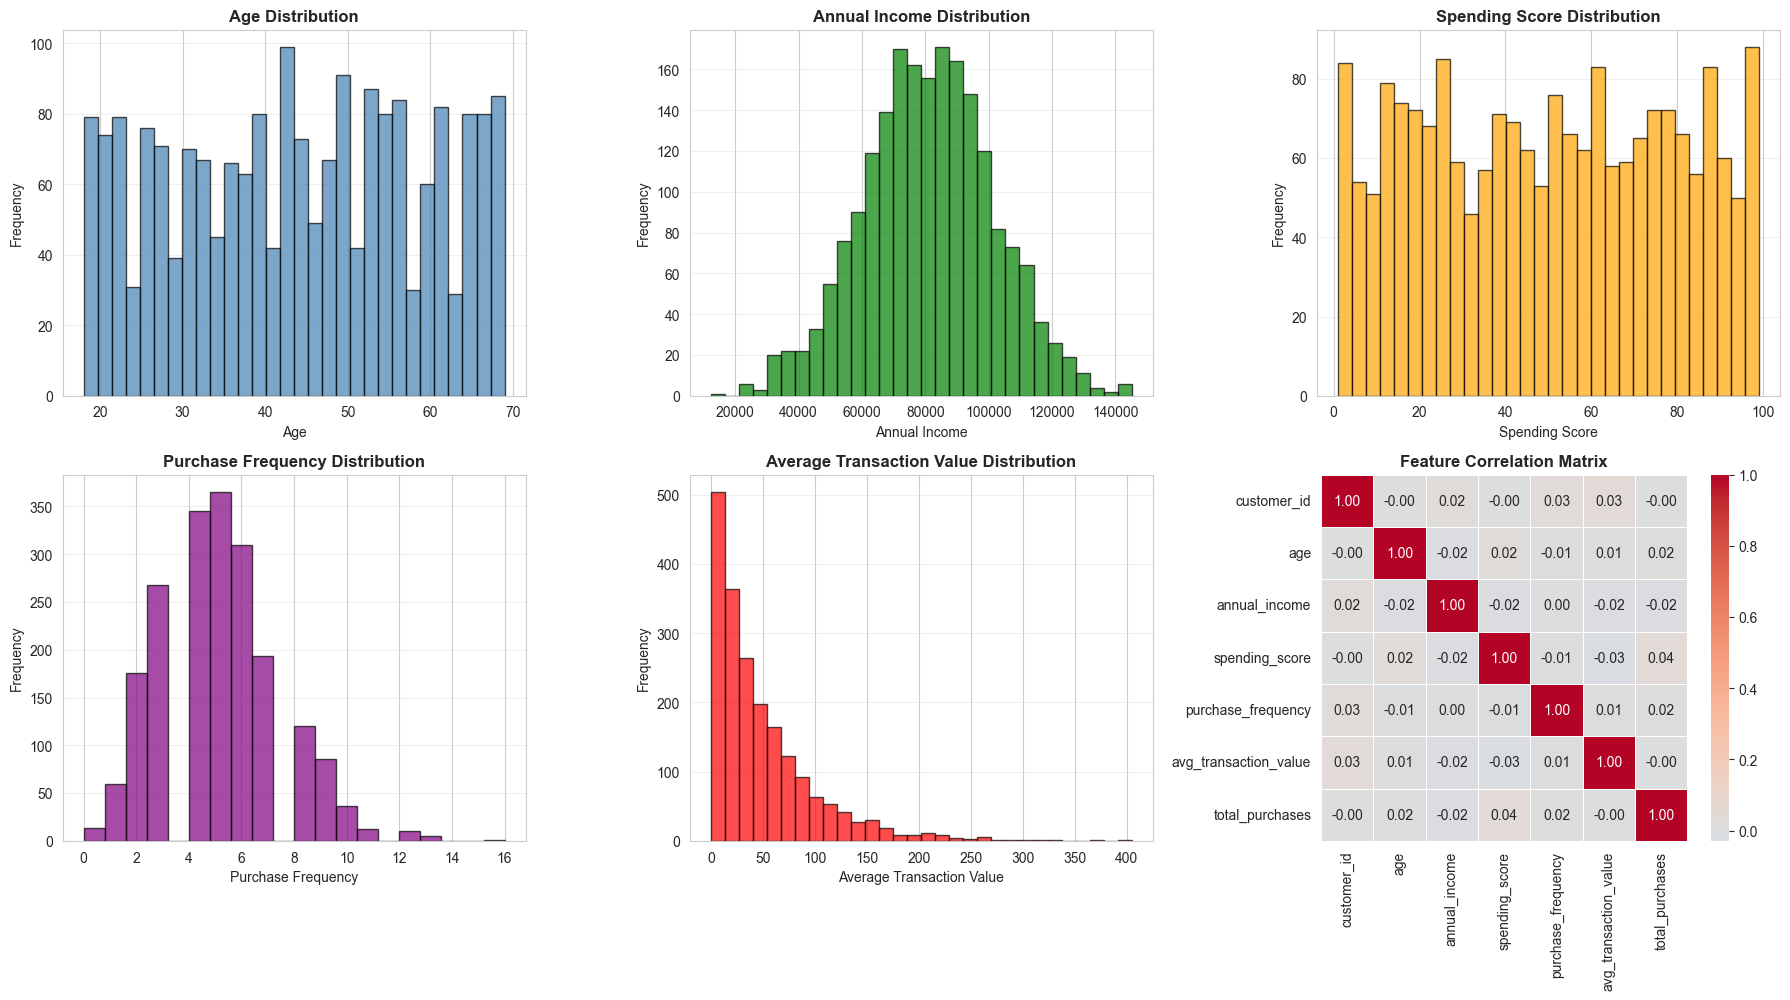

In [14]:
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Age distribution
axes[0, 0].hist(df['age'], bins=30, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_title('Age Distribution', fontsize=12, fontweight='bold')
axes[0, 0].set_xlabel('Age')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].grid(True, alpha=0.3, axis='y')

# Income distribution
axes[0, 1].hist(df['annual_income'], bins=30, edgecolor='black', alpha=0.7, color='green')
axes[0, 1].set_title('Annual Income Distribution', fontsize=12, fontweight='bold')
axes[0, 1].set_xlabel('Annual Income')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3, axis='y')

# Spending score distribution
axes[0, 2].hist(df['spending_score'], bins=30, edgecolor='black', alpha=0.7, color='orange')
axes[0, 2].set_title('Spending Score Distribution', fontsize=12, fontweight='bold')
axes[0, 2].set_xlabel('Spending Score')
axes[0, 2].set_ylabel('Frequency')
axes[0, 2].grid(True, alpha=0.3, axis='y')

# Purchase frequency
axes[1, 0].hist(df['purchase_frequency'], bins=20, edgecolor='black', alpha=0.7, color='purple')
axes[1, 0].set_title('Purchase Frequency Distribution', fontsize=12, fontweight='bold')
axes[1, 0].set_xlabel('Purchase Frequency')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Average transaction value
axes[1, 1].hist(df['avg_transaction_value'], bins=30, edgecolor='black', alpha=0.7, color='red')
axes[1, 1].set_title('Average Transaction Value Distribution', fontsize=12, fontweight='bold')
axes[1, 1].set_xlabel('Average Transaction Value')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].grid(True, alpha=0.3, axis='y')

# Correlation heatmap
correlation = df.corr()
sns.heatmap(correlation, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=0.5, ax=axes[1, 2], fmt='.2f')
axes[1, 2].set_title('Feature Correlation Matrix', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

**Data Preprocessing**

In [15]:
feature_cols = ['age', 'annual_income', 'spending_score', 
                'purchase_frequency', 'avg_transaction_value', 'total_purchases']
X = df[feature_cols].values

print(f"Data shape: {X.shape}")

Data shape: (2000, 6)


In [16]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"Scaled data shape: {X_scaled.shape}")
print(f"Mean: {X_scaled.mean(axis=0).round(3)}")
print(f"Std: {X_scaled.std(axis=0).round(3)}")

Scaled data shape: (2000, 6)
Mean: [-0. -0.  0.  0.  0. -0.]
Std: [1. 1. 1. 1. 1. 1.]


**Dimensionality Reduction**